In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
#from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
import time
from time import gmtime, strftime
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2017-05-21 04:36:17


In [3]:
dUS = pd.read_csv("df2_3z_grpTotUSx00.csv",index_col=0)
#dUS = pd.read_csv("df2_3z_grpTotUSx18nohist.csv",index_col=0)
dUS['AsOf'] = pd.to_datetime(dUS['AsOf'])
dUS['qyNIM'] = dUS['qNetII']*400/dUS['aEarnAst']
#dC18 = pd.read_csv("df2_3z_grpC18x00.csv",index_col=0)
#dC18 = pd.read_csv("df2_3z_grpC18x00nohist.csv",index_col=0)
#dC18['AsOf'] = pd.to_datetime(dC18['AsOf'])
#dC18['qyNIM'] = dC18['qNetII']*400/dC18['aEarnAst']
dUS.head(2)

AsOf          Grp  IDRSSD   nbr         Cert       eTotAst  \
0 2001-03-31  grpTotUSx00       0  8857  157908377.0  6.619299e+09   
1 2001-06-30  grpTotUSx00       0  8790  157950414.0  6.670875e+09   

         eTotLn       eALLL      eOREO         eGW    ...         eTotrb  \
0  4.019129e+09  66654030.0  3654979.0  62574356.0    ...      12.424229   
1  4.052104e+09  67717331.0  3794355.0  65356631.0    ...      12.556711   

   eALLL_Ln      mxCx    mxSfFst      mxCRE       mxCI    mxCard      mxDDA  \
0  1.658420  4.526967  19.886307  12.274656  24.493310  5.417228  19.002339   
1  1.671165  4.757107  19.959003  12.389330  23.792958  5.606277  19.502725   

     eRWA_TA   lnTotAst  
0  77.388279  22.613255  
1  77.331733  22.621017  

[2 rows x 320 columns]

In [4]:
## add code for qyCsmr, qrSavNow, qrCD, qyTotII, qrTotIE:
#dUS2 = pd.concat([dUS, dC18],ignore_index=True)
dUS2 = dUS.copy()
dUS2['aCsmr'] = dUS2['aCard']+dUS2['aOthCsmr']
dUS2['qyCsmr'] = dUS2.apply(lambda x: (x['qiCard']+x['qiOthCsmr'])*400/x['aCsmr'],axis=1)
#dUS2['qiOthLnLs'] = dUS2['qiTotLnLs']-dUS2['qiRE']-dUS2['qiCI']-dUS2['qiCard']-dUS2['qiOthCsmr']
#dUS2['aOthLnLs'] = dUS2['aTotLnLs']-dUS2['aTotRE']-dUS2['aCI']-dUS2['aCard']-dUS2['aOthCsmr']
#dUS2['qyOthLnLs'] = dUS2.apply(lambda x: x['qiOthLnLs']*400/x['aOthLnLs'],axis=1)
dUS2['aSavNow'] = dUS2['aSav'] + dUS2['aNOW']
dUS2['aCD'] = dUS2['aCDun'] + dUS2['aCDov']
dUS2['qrSavNow'] = dUS2.apply(lambda x: (x['qeSav']+x['qeNOW'])*400/(x['aSav']+x['aNOW']),axis=1)
dUS2['qrCD'] = dUS2.apply(lambda x: (x['qeCDun']+x['qeCDov'])*400/(x['aCDun']+x['aCDov']),axis=1)
dUS2['netDDA'] = dUS2['aEarnAst'] - dUS2['aDepIB'] - dUS2['aOLbIB'] - dUS2['eTangEq']
# calc qyTotII, qrTotIE:
dUS2['qyTotII'] = dUS2.apply(lambda x: x['qiTotII']*400/x['aEarnAst'],axis=1)
dUS2['qrTotIE'] = dUS2.apply(lambda x: x['qeTotIE']*400/x['aEarnAst'],axis=1)
dUS2.tail()

AsOf        Grp  IDRSSD  nbr       Cert       eTotAst        eTotLn  \
315 2015-12-31  grpC31x00       0   57  1154163.0  1.103416e+10  5.629865e+09   
316 2016-03-31  grpC31x00       0   57  1154163.0  1.127247e+10  5.692954e+09   
317 2016-06-30  grpC31x00       0   56  1146749.0  1.144652e+10  5.778812e+09   
318 2016-09-30  grpC31x00       0   55  1133074.0  1.156227e+10  5.824476e+09   
319 2016-12-31  grpC31x00       0   54  1117070.0  1.148675e+10  5.832861e+09   

          eALLL      eOREO          eGW     ...           mxDDA    eRWA_TA  \
315  77417155.0  4493946.0  230935346.0     ...       31.411856  73.371583   
316  78936810.0  4192035.0  232636987.0     ...       30.482285  72.553637   
317  79157774.0  3915105.0  233200800.0     ...       30.597264  71.617010   
318  78916907.0  3558030.0  233974738.0     ...       31.168489  70.777553   
319  77827643.0  3350232.0  233448068.0     ...       30.672306  71.183240   

      lnTotAst         aCsmr    qyCsmr       aSavNow          aCD  qrSavNow  \
315  23.124262  1.061436e+09  8.521725  5.302175e+09  780507271.0  0.109402   
316  23.145630  1.068970e+09  8.504878  5.372308e+09  802392616.0  0.123538   
317  23.160952  1.077115e+09  8.383860  5.520687e+09  802207503.0  0.128498   
318  23.171013  1.098205e+09  8.571065  5.625556e+09  790477327.0  0.131755   
319  23.164460  1.122043e+09  8.694691  5.759610e+09  749527974.0  0.144476   

         qrCD       netDDA  
315  0.631093  811220976.0  
316  0.765032  773555210.0  
317  0.845614  765412699.0  
318  0.876221  792046686.0  
319  0.946784  822845485.0  

[5 rows x 327 columns]

In [5]:
dUS2[['Grp','eTotAst']].groupby('Grp').count()

eTotAst
Grp                 
grpC18x00         64
grpC31x00         64
grpTotUSx00       64
grpTotUSx18       64
grpTotUSx31       64

In [6]:
#####################################################################
#####################################################################
grp = 'grpTotUSx00'
#grp = 'grpTotUSx18'
#grp = 'grpTotUSx18nohist'
#grp = 'grpC18x00'
#grp = 'grpC18x00nohist'
dy3 = dUS2[dUS2['Grp']==grp]
dy3.set_index('AsOf',drop=True,inplace=True)
dy3.head(2)

Grp  IDRSSD   nbr         Cert       eTotAst  \
AsOf                                                               
2001-03-31  grpTotUSx00       0  8857  157908377.0  6.619299e+09   
2001-06-30  grpTotUSx00       0  8790  157950414.0  6.670875e+09   

                  eTotLn       eALLL      eOREO         eGW     eOthInt  \
AsOf                                                                      
2001-03-31  4.019129e+09  66654030.0  3654979.0  62574356.0  41766736.0   
2001-06-30  4.052104e+09  67717331.0  3794355.0  65356631.0  41617476.0   

               ...           mxDDA    eRWA_TA   lnTotAst        aCsmr  \
AsOf           ...                                                      
2001-03-31     ...       19.002339  77.388279  22.613255  565178660.0   
2001-06-30     ...       19.502725  77.331733  22.621017  572302418.0   

               qyCsmr       aSavNow           aCD  qrSavNow      qrCD  \
AsOf                                                                    
2001-03-31  11.318668  1.658162e+09  1.480339e+09  2.777600  5.833631   
2001-06-30  10.708835  1.731745e+09  1.474806e+09  2.369317  5.426207   

                 netDDA  
AsOf                     
2001-03-31  451900692.0  
2001-06-30  443925675.0  

[2 rows x 326 columns]

In [7]:
## get yldreg results and bestSD tables:
#p12 = ['qyRE','qyCI','qyCsmr','qyOthLnLs','qyTotSec','qyOAstIB','DDA','qrSavNow','qrCD','qrFDepIB','qrOLbIB','Prime']
#p6a = ['qyRE','qyCI','qyCsmr','qyOthLnLs','qyTotSec','qyOAstIB']
#p6b = ['DDA','qrSavNow','qrCD','qrFDepIB','qrOLbIB','Prime']
#y9col=['qyRE','qyCI','qyCsmr','qyOthLnLs','qyTotSec','qyOAstIB','DDA','qrSavNow','qrCD','qrOLbIB','Prime']
#yp = ['qyCard','qyCI','qyCsmr','qyNIM','qyOAstIB','qyOthCsmr','qyOthLnLs','qyRE','qyTotII','qyTotSec']
#yp = yp+['qrBorr','qrCD','qrCDov','qrCDun','qrFFP','qrNOW','qrOLbIB','qrSav','qrSavNow','qrFDepIB','qrTotIE']
#yp = yp + ['Prime','DDA']
#bp = ['aCard','aCI','aCsmr','aEarnAst','aOAstIB','aOthCsmr','aOthLnLs','aTotRE','aTotSec']
#bp = bp+['aBorr','aCD','aCDov','aCDun','aFFP','aNOW','aOLbIB','aSav','aSavNow','aFDepIB']
#bp = bp + ['netDDA']
#thr = pd.DataFrame(columns=['Grp','Yrs']+y9col)  # thresolds for max durations
#tcol = list(thr.columns)

In [8]:
#len(yp)

In [9]:
## select time period: 2001-2014, 2001-2007, 2008-2014 (14y, 7y, 7y)
#r0 = '2001_2007'
r0 = '2001_2010'
#r0 = '2001_2014'
#r0 = '2005_2014'
ra = int(r0[0:4])
rb = int(r0[-4:])
r0, ra, rb

('2001_2010', 2001, 2010)

In [10]:
yr = pd.read_csv('yldreg_3mat_FDIC_'+grp+'_'+r0+'_exp.csv', index_col=0)
yrb = pd.read_csv('yldreg_3matbest_FDIC_'+grp+'_'+r0+'_exp.csv', index_col=0)

yrb.head(2)

grp   prod mt1 mt2   mt3   mx1   mx2       dur       spd  \
1178  grpTotUSx00    DDA  r0  r6  r120  0.00  0.05  4.117666 -5.693406   
991   grpTotUSx00  Prime  r0  r1    r6  0.75  0.20  0.020833  3.012379   

            sd  
1178  0.604397  
991   0.052124

In [11]:
yrm = yr.copy()
yrm['lng'] = yrm['mt3']

In [12]:
for i in np.arange(len(yrm)):
  if (yrm.ix[i]['mx1']+yrm.ix[i]['mx2'])<1:
    #yrm.loc[i,'lng'] = yrm.ix[i]['mt3']
    pass
  elif yrm.ix[i]['mx2']>0:
    yrm.loc[i,'lng'] = yrm.ix[i]['mt2']
  else: 
    yrm.loc[i,'lng'] = yrm.ix[i]['mt1']
  if int(i/100)*100 == i:
    print(i)

yrm.head()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


grp  prod mt1 mt2  mt3  mx1  mx2       dur       spd        sd  lng
0  grpTotUSx00  qyRE  r0  r1   r3  0.9  0.0  0.012500  3.709549  1.198003   r3
1  grpTotUSx00  qyRE  r0  r1   r6  0.5  0.0  0.125000  3.470695  1.157829   r6
2  grpTotUSx00  qyRE  r0  r1  r12  0.2  0.0  0.430070  3.165374  1.025736  r12
3  grpTotUSx00  qyRE  r0  r1  r24  0.3  0.0  0.715315  2.808744  0.690836  r24
4  grpTotUSx00  qyRE  r0  r1  r36  0.4  0.0  0.895351  2.650664  0.433659  r36

In [13]:
yrm['lng2'] = yrm.apply(lambda x:  x['lng'][1:],axis=1).astype(int)
yrm.tail()

grp     prod  mt1  mt2   mt3   mx1   mx2       dur       spd  \
1975  grpTotUSx00  qrOLbIB  r36  r84  r120  0.55  0.00  2.765291 -1.222932   
1976  grpTotUSx00  qrOLbIB  r48  r60   r84  0.00  0.00  3.211180 -1.546497   
1977  grpTotUSx00  qrOLbIB  r48  r60  r120  0.00  0.00  4.321228 -2.121833   
1978  grpTotUSx00  qrOLbIB  r48  r84  r120  0.00  0.05  4.265725 -2.093067   
1979  grpTotUSx00  qrOLbIB  r60  r84  r120  0.00  0.05  4.265725 -2.093067   

            sd   lng  lng2  
1975  1.343450  r120   120  
1976  1.417464   r84    84  
1977  1.411984  r120   120  
1978  1.411959  r120   120  
1979  1.411959  r120   120

In [14]:
yrm[(yrm['prod']=='Prime')].head()

grp   prod mt1 mt2  mt3   mx1   mx2       dur       spd  \
990  grpTotUSx00  Prime  r0  r1   r3  0.75  0.15  0.018750  3.014305   
991  grpTotUSx00  Prime  r0  r1   r6  0.75  0.20  0.020833  3.012379   
992  grpTotUSx00  Prime  r0  r1  r12  0.75  0.20  0.035213  3.003561   
993  grpTotUSx00  Prime  r0  r1  r24  0.75  0.25  0.010417  3.030337   
994  grpTotUSx00  Prime  r0  r1  r36  0.75  0.25  0.010417  3.030337   

           sd  lng  lng2  
990  0.053576   r3     3  
991  0.052124   r6     6  
992  0.055423  r12    12  
993  0.056925   r1     1  
994  0.056925   r1     1

In [15]:
len(yrm) # 1980

1980

In [16]:
yrm2 = yrm.ix[yrm.groupby(['prod','lng2']).apply(lambda x: x['sd'].idxmin())]
len(yrm2) # 108

108

In [17]:
yrm2.to_csv('yldreg_3matlngfam_FDIC_'+grp+'_'+r0+'_exp.csv')

In [18]:
yrm2.reset_index(drop=True,inplace=True)
yrm2['bst'] = np.nan
yrm2[yrm2['prod']=='DDA']

grp prod mt1  mt2   mt3   mx1   mx2       dur       spd        sd  \
0  grpTotUSx00  DDA  r0   r1    r3  0.10  0.00  0.112500 -2.695362  1.818578   
1  grpTotUSx00  DDA  r0   r1    r6  0.00  0.00  0.250000 -2.929052  1.756327   
2  grpTotUSx00  DDA  r0   r1   r12  0.00  0.05  0.512792 -3.078643  1.712522   
3  grpTotUSx00  DDA  r0   r1   r24  0.10  0.00  0.919691 -3.584623  1.387378   
4  grpTotUSx00  DDA  r0   r1   r36  0.00  0.15  1.274664 -3.959338  1.018613   
5  grpTotUSx00  DDA  r0   r1   r48  0.00  0.15  1.661253 -4.256987  0.761571   
6  grpTotUSx00  DDA  r0   r3   r60  0.00  0.15  2.046392 -4.509544  0.673718   
7  grpTotUSx00  DDA  r6  r60   r84  0.15  0.75  2.147714 -4.583371  0.674261   
8  grpTotUSx00  DDA  r0   r6  r120  0.00  0.05  4.117666 -5.693406  0.604397   

    lng  lng2  bst  
0    r3     3  NaN  
1    r6     6  NaN  
2   r12    12  NaN  
3   r24    24  NaN  
4   r36    36  NaN  
5   r48    48  NaN  
6   r60    60  NaN  
7   r84    84  NaN  
8  r120   120  NaN

In [19]:
yrm2.sort_index(inplace=True,by=['prod','dur','lng2'])
yrm2[['dur_1','sd_1']] = yrm2.groupby(['prod'])[['dur','sd']].shift(1)
yrm2[yrm2['prod']=='qyOthLnLs']

grp       prod mt1  mt2   mt3   mx1  mx2       dur       spd  \
81  grpTotUSx00  qyOthLnLs  r0   r1    r3  0.45  0.0  0.068750  3.101042   
82  grpTotUSx00  qyOthLnLs  r0   r1    r6  0.25  0.0  0.187500  2.882200   
83  grpTotUSx00  qyOthLnLs  r0   r1   r12  0.20  0.0  0.430070  2.713735   
84  grpTotUSx00  qyOthLnLs  r0   r1   r24  0.30  0.0  0.715315  2.357105   
85  grpTotUSx00  qyOthLnLs  r0   r1   r36  0.40  0.0  0.895351  2.199025   
87  grpTotUSx00  qyOthLnLs  r0  r48   r60  0.45  0.5  1.092804  2.084133   
86  grpTotUSx00  qyOthLnLs  r0   r6   r48  0.35  0.1  1.095884  2.042832   
88  grpTotUSx00  qyOthLnLs  r1  r48   r84  0.40  0.5  1.311316  1.842724   
89  grpTotUSx00  qyOthLnLs  r0  r48  r120  0.40  0.5  1.405654  1.860501   

          sd   lng  lng2  bst     dur_1      sd_1  
81  1.163380    r3     3  NaN       NaN       NaN  
82  1.101735    r6     6  NaN  0.068750  1.163380  
83  1.016133   r12    12  NaN  0.187500  1.101735  
84  0.717574   r24    24  NaN  0.430070  1.016133  
85  0.459098   r36    36  NaN  0.715315  0.717574  
87  0.346928   r60    60  NaN  0.895351  0.459098  
86  0.343466   r48    48  NaN  1.092804  0.346928  
88  0.360740   r84    84  NaN  1.095884  0.343466  
89  0.345165  r120   120  NaN  1.311316  0.360740

In [20]:
yrm2['slp'] = yrm2.apply(lambda x: (x['sd']-x['sd_1'])/(x['dur']-x['dur_1']),axis=1)
## remove all positive slopes, then recalc slopes
yrm2z = yrm2[(yrm2['slp']<0)|(yrm2['slp'].isnull())]  
yrm2z['prod_1'] = yrm2z['prod'].shift(1)
yrm2z[['dur_1','sd_1']] = yrm2z.groupby(['prod'])[['dur','sd']].shift(1)
## calc slope (unless it is 1st row for this product)
yrm2z['slp'] = yrm2z.apply(lambda x: (x['sd']-x['sd_1'])/(x['dur']-x['dur_1']) if x['prod']==x['prod_1'] else np.nan,axis=1)
yrm2z[yrm2z['prod']=='qyOthLnLs']

grp       prod mt1  mt2   mt3   mx1  mx2       dur       spd  \
81  grpTotUSx00  qyOthLnLs  r0   r1    r3  0.45  0.0  0.068750  3.101042   
82  grpTotUSx00  qyOthLnLs  r0   r1    r6  0.25  0.0  0.187500  2.882200   
83  grpTotUSx00  qyOthLnLs  r0   r1   r12  0.20  0.0  0.430070  2.713735   
84  grpTotUSx00  qyOthLnLs  r0   r1   r24  0.30  0.0  0.715315  2.357105   
85  grpTotUSx00  qyOthLnLs  r0   r1   r36  0.40  0.0  0.895351  2.199025   
87  grpTotUSx00  qyOthLnLs  r0  r48   r60  0.45  0.5  1.092804  2.084133   
86  grpTotUSx00  qyOthLnLs  r0   r6   r48  0.35  0.1  1.095884  2.042832   
89  grpTotUSx00  qyOthLnLs  r0  r48  r120  0.40  0.5  1.405654  1.860501   

          sd   lng  lng2  bst     dur_1      sd_1       slp     prod_1  
81  1.163380    r3     3  NaN       NaN       NaN       NaN   qyOAstIB  
82  1.101735    r6     6  NaN  0.068750  1.163380 -0.519110  qyOthLnLs  
83  1.016133   r12    12  NaN  0.187500  1.101735 -0.352897  qyOthLnLs  
84  0.717574   r24    24  NaN  0.430070  1.016133 -1.046677  qyOthLnLs  
85  0.459098   r36    36  NaN  0.715315  0.717574 -1.435687  qyOthLnLs  
87  0.346928   r60    60  NaN  0.895351  0.459098 -0.568087  qyOthLnLs  
86  0.343466   r48    48  NaN  1.092804  0.346928 -1.124085  qyOthLnLs  
89  0.345165  r120   120  NaN  1.095884  0.343466  0.005485  qyOthLnLs

In [21]:
ynull=yrm2z[yrm2z['slp'].isnull()]
ynull.tail()

grp       prod mt1 mt2 mt3   mx1  mx2      dur       spd  \
63  grpTotUSx00     qyCsmr  r0  r1  r3  0.40  0.0  0.07500  6.626317   
72  grpTotUSx00   qyOAstIB  r0  r1  r3  0.45  0.0  0.06875  0.192339   
81  grpTotUSx00  qyOthLnLs  r0  r1  r3  0.45  0.0  0.06875  3.101042   
90  grpTotUSx00       qyRE  r0  r1  r3  0.90  0.0  0.01250  3.709549   
99  grpTotUSx00   qyTotSec  r0  r1  r3  0.15  0.0  0.10625  1.820992   

          sd lng  lng2  bst  dur_1  sd_1  slp     prod_1  
63  1.575353  r3     3  NaN    NaN   NaN  NaN       qyCI  
72  0.726398  r3     3  NaN    NaN   NaN  NaN     qyCsmr  
81  1.163380  r3     3  NaN    NaN   NaN  NaN   qyOAstIB  
90  1.198003  r3     3  NaN    NaN   NaN  NaN  qyOthLnLs  
99  1.446865  r3     3  NaN    NaN   NaN  NaN       qyRE

In [22]:
yrm2za = yrm2z[(yrm2z['prod']==yrm2z['prod_1'])&(yrm2z['slp']>-2)]
yrm2za[yrm2za['prod']=='qyCI'].head()

grp  prod mt1 mt2  mt3  mx1  mx2       dur       spd        sd  \
56  grpTotUSx00  qyCI  r0  r1  r12  0.7  0.0  0.161276  3.694451  0.863390   
57  grpTotUSx00  qyCI  r0  r1  r24  0.6  0.0  0.408752  3.376923  0.702397   
58  grpTotUSx00  qyCI  r0  r1  r36  0.6  0.0  0.596901  3.182426  0.537307   
59  grpTotUSx00  qyCI  r0  r1  r48  0.6  0.0  0.778825  3.042356  0.418404   
60  grpTotUSx00  qyCI  r0  r1  r60  0.6  0.0  0.954185  2.934822  0.367545   

    lng  lng2  bst     dur_1      sd_1       slp prod_1  
56  r12    12  NaN  0.000000  0.894331 -0.191851   qyCI  
57  r24    24  NaN  0.161276  0.863390 -0.650541   qyCI  
58  r36    36  NaN  0.408752  0.702397 -0.877439   qyCI  
59  r48    48  NaN  0.596901  0.537307 -0.653587   qyCI  
60  r60    60  NaN  0.778825  0.418404 -0.290029   qyCI

In [23]:
## get min (steepest) point, divide by 3 as filter for candidate points:
slpn = yrm2za[['prod','slp']].ix[yrm2za.groupby(['prod']).apply(lambda x: x['slp'].idxmin())]
slpn.rename(columns={'slp':'slpn'},inplace=True)
yrm2a = yrm2za.merge(slpn,on='prod')
###########################################
rtyp=4 ## steepness ratio base.. best is 4  # 20160328
###########################################
yrm2b=yrm2a[yrm2a['slp']<(yrm2a['slpn']/rtyp)]  ## selection ratio here:  1/3 works well
#yrm2b[yrm2b['prod']=='qyCard']
yrm3 = yrm2b.ix[yrm2b.groupby(['prod']).apply(lambda x: x['dur'].idxmax())]
yrm3['bst'] = 'x'
yrm3.tail(8)

grp       prod mt1  mt2  mt3   mx1   mx2       dur       spd  \
24  grpTotUSx00    qrOLbIB  r0   r1  r36  0.75  0.00  0.373063  0.879713   
30  grpTotUSx00   qrSavNow  r0   r1  r48  0.15  0.25  1.178654 -2.520595   
37  grpTotUSx00       qyCI  r0   r1  r60  0.60  0.00  0.954185  2.934822   
43  grpTotUSx00     qyCsmr  r0  r36  r48  0.25  0.10  1.414816  5.240680   
49  grpTotUSx00   qyOAstIB  r0   r1  r48  0.25  0.40  0.698139 -0.451823   
55  grpTotUSx00  qyOthLnLs  r0   r6  r48  0.35  0.10  1.095884  2.042832   
61  grpTotUSx00       qyRE  r0   r1  r48  0.40  0.00  1.168238  2.440559   
68  grpTotUSx00   qyTotSec  r0   r6  r48  0.00  0.30  1.437944  0.431913   

          sd  lng  lng2 bst     dur_1      sd_1       slp     prod_1      slpn  
24  0.214556  r36    36   x  0.306564  0.272176 -0.866482    qrOLbIB -1.334214  
30  0.365478  r48    48   x  0.897434  0.528753 -0.580594   qrSavNow -1.153752  
37  0.367545  r60    60   x  0.778825  0.418404 -0.290029       qyCI -0.877439  
43  0.617770  r48    48   x  1.193801  0.688353 -0.319357     qyCsmr -1.035722  
49  0.230264  r48    48   x  0.607317  0.295218 -0.715187   qyOAstIB -1.255579  
55  0.343466  r48    48   x  1.092804  0.346928 -1.124085  qyOthLnLs -1.435687  
61  0.328549  r48    48   x  0.895351  0.433659 -0.385180       qyRE -1.428474  
68  0.305873  r48    48   x  1.193801  0.419593 -0.465794   qyTotSec -1.402675

In [24]:
yrm4 = pd.concat([yrm3,ynull],axis=0)
yrm4 = yrm4[yrm3.columns]
yrm4.sort_index(by='prod',inplace=True)
yrm4.reset_index(drop=True,inplace=True)
yrm5 = yrm4.ix[yrm4.groupby(['prod']).apply(lambda x: x['sd'].idxmin())]
yrm5.tail()

grp       prod mt1  mt2  mt3   mx1  mx2       dur       spd  \
15  grpTotUSx00     qyCsmr  r0  r36  r48  0.25  0.1  1.414816  5.240680   
17  grpTotUSx00   qyOAstIB  r0   r1  r48  0.25  0.4  0.698139 -0.451823   
19  grpTotUSx00  qyOthLnLs  r0   r6  r48  0.35  0.1  1.095884  2.042832   
21  grpTotUSx00       qyRE  r0   r1  r48  0.40  0.0  1.168238  2.440559   
22  grpTotUSx00   qyTotSec  r0   r6  r48  0.00  0.3  1.437944  0.431913   

          sd  lng  lng2 bst     dur_1      sd_1       slp     prod_1      slpn  
15  0.617770  r48    48   x  1.193801  0.688353 -0.319357     qyCsmr -1.035722  
17  0.230264  r48    48   x  0.607317  0.295218 -0.715187   qyOAstIB -1.255579  
19  0.343466  r48    48   x  1.092804  0.346928 -1.124085  qyOthLnLs -1.435687  
21  0.328549  r48    48   x  0.895351  0.433659 -0.385180       qyRE -1.428474  
22  0.305873  r48    48   x  1.193801  0.419593 -0.465794   qyTotSec -1.402675

In [25]:
len(yrm5)

12

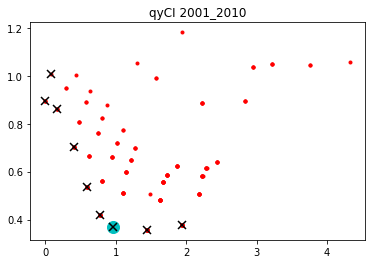

In [26]:
pr = 'qyCI'
olp = yrm[yrm['prod']==pr]
ols = yrm2[yrm2['prod']==pr]
ols3 = yrm5[yrm5['prod']==pr]
plt.plot(olp['dur'],olp['sd'],ls=' ',marker='.',mec='r',c='r')
plt.plot(ols3['dur'],ols3['sd'],ls=' ',marker='o',ms=12,c='c',mec='c')
plt.plot(ols['dur'],ols['sd'],ls=' ',marker='x',mec='k',ms=8,mew=1.5)
#plt.xlim([0,1])
#plt.ylim([0,1.5])
plt.title(pr+' '+r0)
plt.savefig('lngfam_'+pr+'_'+r0+'_'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [27]:
ols3

grp  prod mt1 mt2  mt3  mx1  mx2       dur       spd        sd  \
13  grpTotUSx00  qyCI  r0  r1  r60  0.6  0.0  0.954185  2.934822  0.367545   

    lng  lng2 bst     dur_1      sd_1       slp prod_1      slpn  
13  r60    60   x  0.778825  0.418404 -0.290029   qyCI -0.877439

In [28]:
yrm5.to_csv('yldreg_3mataltbest_FDIC_'+grp+'_'+r0+'_exp'+str(rtyp)+'.csv') # 20160328 add 'rtyp' steepness ratio flag
len(yrm5)

12

In [29]:
p6a = ['qyRE', 'qyCI', 'qyCsmr', 'qyOthLnLs', 'qyTotSec', 'qyOAstIB']
p6b = ['DDA', 'qrSavNow', 'qrCD', 'qrFDepIB', 'qrOLbIB', 'Prime']
p6a, p6b

(['qyRE', 'qyCI', 'qyCsmr', 'qyOthLnLs', 'qyTotSec', 'qyOAstIB'],
 ['DDA', 'qrSavNow', 'qrCD', 'qrFDepIB', 'qrOLbIB', 'Prime'])

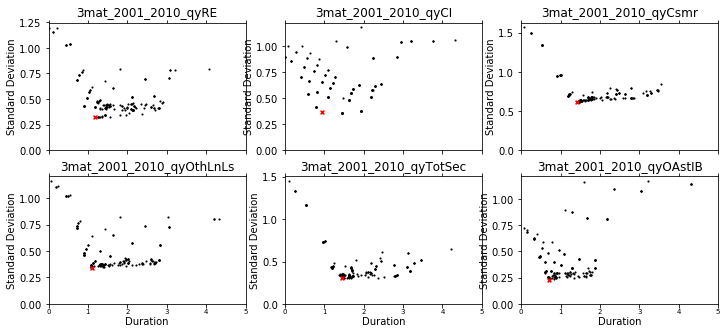

In [30]:
###### plt.rcParams.update({'font.size': 7})
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )  ## double width, single height

for i in np.arange(6):
  plt.subplot(3, 3, i+1)
  plt.scatter(yr[yr['prod']==p6a[i]]['dur'],yr[yr['prod']==p6a[i]]['sd'],c='k',marker = '.',s=5)
  plt.scatter(yrm3[yrm3['prod']==p6a[i]]['dur'],yrm3[yrm3['prod']==p6a[i]]['sd'],c='r',marker = 'x',s=15)
  plt.ylim(ymin=0)
  plt.ylabel('Standard Deviation',labelpad=2)
  plt.title('3mat_'+r0+'_'+p6a[i])
  plt.xlim(0,5)

  if i < 3:
    labl = 'off'
    plt.xlabel('',labelpad=2)
  else:
    labl = 'on'
    plt.xlabel('Duration',labelpad=2)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.4,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('3mat_'+grp+'_'+r0+'_a'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

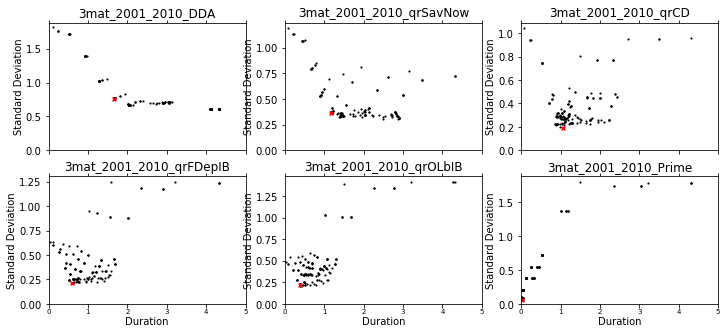

In [31]:
###### plt.rcParams.update({'font.size': 7})
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )  ## double width, single height

for i in np.arange(6):
  plt.subplot(3, 3, i+1)
  plt.scatter(yr[yr['prod']==p6b[i]]['dur'],yr[yr['prod']==p6b[i]]['sd'],c='k',marker = '.',s=5)
  plt.scatter(yrm3[yrm3['prod']==p6b[i]]['dur'],yrm3[yrm3['prod']==p6b[i]]['sd'],c='r',marker = 'x',s=15)
  plt.ylim(ymin=0)
  plt.ylabel('Standard Deviation',labelpad=2)
  plt.title('3mat_'+r0+'_'+p6b[i])
  plt.xlim(0,5)

  if i < 3:
    labl = 'off'
    plt.xlabel('',labelpad=2)
  else:
    labl = 'on'
    plt.xlabel('Duration',labelpad=2)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.4,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('3mat_'+grp+'_'+r0+'_b'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [32]:
yre=pd.concat([yrb,yrm5]).drop_duplicates().reset_index(drop=True)
#yre = yrm3.copy()
yre['dur2'] = yre.apply(lambda x: round(x['dur'],2),axis=1)
yre['sd2'] = yre.apply(lambda x: round(x['sd'],2),axis=1)
len(yre)

24

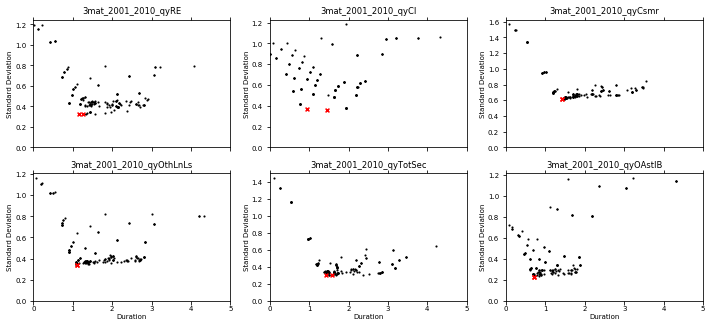

In [33]:
plt.rcParams.update({'font.size': 7})
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )  ## double width, single height

for i in np.arange(6):
  plt.subplot(3, 3, i+1)
  plt.scatter(yr[yr['prod']==p6a[i]]['dur'],yr[yr['prod']==p6a[i]]['sd'],c='k',marker = '.',s=5)
  plt.scatter(yre[yre['prod']==p6a[i]]['dur'],yre[yre['prod']==p6a[i]]['sd'],c='r',marker = 'x',s=15)
  plt.ylim(ymin=0)
  plt.ylabel('Standard Deviation',labelpad=2)
  plt.title('3mat_'+r0+'_'+p6a[i])
  plt.xlim(0,5)

  if i < 3:
    labl = 'off'
    plt.xlabel('',labelpad=2)
  else:
    labl = 'on'
    plt.xlabel('Duration',labelpad=2)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.4,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('3mat_altbest_'+grp+'_'+r0+'_a'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

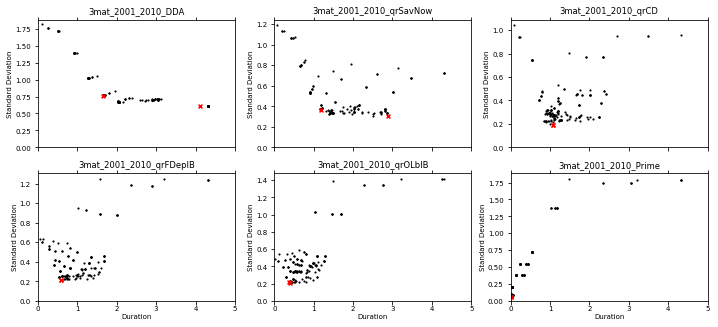

In [34]:
plt.rcParams.update({'font.size': 7})
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )  ## double width, single height

for i in np.arange(6):
  plt.subplot(3, 3, i+1)
  plt.scatter(yr[yr['prod']==p6b[i]]['dur'],yr[yr['prod']==p6b[i]]['sd'],c='k',marker = '.',s=5)
  plt.scatter(yre[yre['prod']==p6b[i]]['dur'],yre[yre['prod']==p6b[i]]['sd'],c='r',marker = 'x',s=15)
  plt.ylim(ymin=0)
  plt.ylabel('Standard Deviation',labelpad=2)
  plt.title('3mat_'+r0+'_'+p6b[i])
  plt.xlim(0,5)

  if i < 3:
    labl = 'off'
    plt.xlabel('',labelpad=2)
  else:
    labl = 'on'
    plt.xlabel('Duration',labelpad=2)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.4,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('3mat_altbest_'+grp+'_'+r0+'_b'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

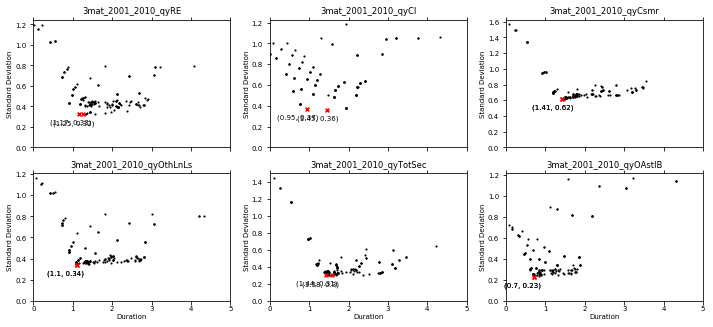

In [35]:
plt.rcParams.update({'font.size': 7})
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )  ## double width, single height

for i in np.arange(6):
  plt.subplot(3, 3, i+1)
  plt.scatter(yr[yr['prod']==p6a[i]]['dur'],yr[yr['prod']==p6a[i]]['sd'],c='k',marker = '.',s=5)
  plt.scatter(yre[yre['prod']==p6a[i]]['dur'],yre[yre['prod']==p6a[i]]['sd'],c='r',marker = 'x',s=15)
  plt.ylim(ymin=0)
  plt.ylabel('Standard Deviation',labelpad=2)
  plt.title('3mat_'+r0+'_'+p6a[i])
  plt.xlim(0,5)
  for xy in zip(yre[yre['prod']==p6a[i]]['dur2'], yre[yre['prod']==p6a[i]]['sd2']): # <--
    plt.annotate('(%s, %s)' % xy, xy=xy, xytext=(-30,-10),textcoords='offset points') # <--

  if i < 3:
    labl = 'off'
    plt.xlabel('',labelpad=2)
  else:
    labl = 'on'
    plt.xlabel('Duration',labelpad=2)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.4,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('3mat_altbest2_'+grp+'_'+r0+'_a'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

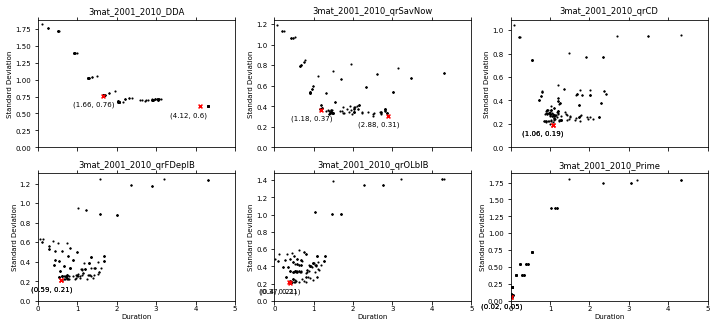

In [36]:
plt.rcParams.update({'font.size': 7})
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*2, plSize[1]*2) )  ## double width, single height

for i in np.arange(6):
  plt.subplot(3, 3, i+1)
  plt.scatter(yr[yr['prod']==p6b[i]]['dur'],yr[yr['prod']==p6b[i]]['sd'],c='k',marker = '.',s=5)
  plt.scatter(yre[yre['prod']==p6b[i]]['dur'],yre[yre['prod']==p6b[i]]['sd'],c='r',marker = 'x',s=15)
  plt.ylim(ymin=0)
  plt.ylabel('Standard Deviation',labelpad=2)
  plt.title('3mat_'+r0+'_'+p6b[i])
  plt.xlim(0,5)
  for xy in zip(yre[yre['prod']==p6b[i]]['dur2'], yre[yre['prod']==p6b[i]]['sd2']): # <--
    plt.annotate('(%s, %s)' % xy, xy=xy, xytext=(-30,-10),textcoords='offset points') # <--

  if i < 3:
    labl = 'off'
    plt.xlabel('',labelpad=2)
  else:
    labl = 'on'
    plt.xlabel('Duration',labelpad=2)
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='on',         # ticks along the top edge are off
    pad = 1.4,        # move labels closer to frame
    labelsize = 7,    # decrease font size of year labels
    labelbottom=labl) # labels along the bottom edge are off

plt.savefig('3mat_altbest2_'+grp+'_'+r0+'_b'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [37]:
#ybst=yrm4[yrm4['prod'].isin(p9s)][['prod','dur']]
ybst=yrm5[['prod','dur']]
ybst

prod       dur
0         DDA  1.661253
2       Prime  0.020833
4        qrCD  1.064334
6    qrFDepIB  0.590369
8     qrOLbIB  0.373063
11   qrSavNow  1.178654
13       qyCI  0.954185
15     qyCsmr  1.414816
17   qyOAstIB  0.698139
19  qyOthLnLs  1.095884
21       qyRE  1.168238
22   qyTotSec  1.437944

In [38]:
ddct = dict(zip(ybst['prod'],ybst['dur']))
ddct

{'DDA': 1.6612531511109747,
 'Prime': 0.020833333333333332,
 'qrCD': 1.0643338260176618,
 'qrFDepIB': 0.59036875921563792,
 'qrOLbIB': 0.3730629567006275,
 'qrSavNow': 1.1786541850979428,
 'qyCI': 0.95418467249692396,
 'qyCsmr': 1.4148158276474667,
 'qyOAstIB': 0.69813855241824441,
 'qyOthLnLs': 1.0958843918953365,
 'qyRE': 1.1682375184312759,
 'qyTotSec': 1.4379437715031551}

In [39]:
dy3.head()

Grp  IDRSSD   nbr         Cert       eTotAst  \
AsOf                                                               
2001-03-31  grpTotUSx00       0  8857  157908377.0  6.619299e+09   
2001-06-30  grpTotUSx00       0  8790  157950414.0  6.670875e+09   
2001-09-30  grpTotUSx00       0  8758  158572066.0  6.869470e+09   
2001-12-31  grpTotUSx00       0  8689  158549775.0  6.886931e+09   
2002-03-31  grpTotUSx00       0  8605  157265826.0  6.821466e+09   

                  eTotLn       eALLL      eOREO         eGW     eOthInt  \
AsOf                                                                      
2001-03-31  4.019129e+09  66654030.0  3654979.0  62574356.0  41766736.0   
2001-06-30  4.052104e+09  67717331.0  3794355.0  65356631.0  41617476.0   
2001-09-30  4.055847e+09  70197634.0  4031762.0  74300359.0  41400992.0   
2001-12-31  4.087280e+09  74347220.0  4098092.0  79747462.0  46140555.0   
2002-03-31  4.084967e+09  77054630.0  4352285.0  82687154.0  52499385.0   

               ...           mxDDA    eRWA_TA   lnTotAst        aCsmr  \
AsOf           ...                                                      
2001-03-31     ...       19.002339  77.388279  22.613255  565178660.0   
2001-06-30     ...       19.502725  77.331733  22.621017  572302418.0   
2001-09-30     ...       19.853057  76.374407  22.650353  575963098.0   
2001-12-31     ...       21.539886  76.567668  22.652891  578824772.0   
2002-03-31     ...       19.906120  76.417674  22.643340  610074161.0   

               qyCsmr       aSavNow           aCD  qrSavNow      qrCD  \
AsOf                                                                    
2001-03-31  11.318668  1.658162e+09  1.480339e+09  2.777600  5.833631   
2001-06-30  10.708835  1.731745e+09  1.474806e+09  2.369317  5.426207   
2001-09-30  10.177399  1.801038e+09  1.459960e+09  1.980128  4.869761   
2001-12-31  10.283806  1.906292e+09  1.432963e+09  1.468420  4.412686   
2002-03-31  10.081662  1.997442e+09  1.389538e+09  1.196821  3.866663   

                 netDDA  
AsOf                     
2001-03-31  451900692.0  
2001-06-30  443925675.0  
2001-09-30  444856854.0  
2001-12-31  524536462.0  
2002-03-31  531046485.0  

[5 rows x 326 columns]

In [40]:
#p9 = ['qyRE','qyCI','qyCsmr','qyTotSec','qyOAstIB','DDA','qrSavNow','qrCD','qrOLbIB']
dy3['durbal']=dy3.apply(lambda x: x['aTotRE']*ddct['qyRE']+x['aCI']*ddct['qyCI']+x['aCsmr']*ddct['qyCsmr']+\
            x['aOthLnLs']*ddct['qyOthLnLs']+\
            x['aTotSec']*ddct['qyTotSec']+x['aOAstIB']*ddct['qyOAstIB']-x['netDDA']*ddct['DDA']-\
            x['aSavNow']*ddct['qrSavNow']-x['aCD']*ddct['qrCD']-x['aFDepIB']*ddct['qrFDepIB']-x['aOLbIB']*ddct['qrOLbIB'],axis=1)
dy3['dur'] = dy3.apply(lambda x:x['durbal']/x['eTangEq'],axis=1)
dy3['durAbal']=dy3.apply(lambda x: x['aTotRE']*ddct['qyRE']+x['aCI']*ddct['qyCI']+x['aCsmr']*ddct['qyCsmr']+\
            x['aOthLnLs']*ddct['qyOthLnLs']+\
            x['aTotSec']*ddct['qyTotSec']+x['aOAstIB']*ddct['qyOAstIB'],axis=1)
dy3['durA'] = dy3.apply(lambda x:x['durAbal']/x['aEarnAst'],axis=1)
dy3['durLbal']=dy3.apply(lambda x: x['netDDA']*ddct['DDA']+x['aSavNow']*ddct['qrSavNow']+\
            x['aCD']*ddct['qrCD']+x['aFDepIB']*ddct['qrFDepIB']+x['aOLbIB']*ddct['qrOLbIB'],axis=1)
dy3['durL'] = dy3.apply(lambda x:x['durLbal']/(x['aEarnAst']-x['eTangEq']),axis=1)
#dy3['durbal2']=dy3.apply(lambda x: x['aTotRE']*ddct['qyRE']+x['aCI']*ddct['qyCI']+x['aCard']*ddct['qyCard']+\
#            x['aOthCsmr']*ddct['qyOthCsmr']+x['aOthLnLs']*ddct['qyOthLnLs']+\
#            x['aTotSec']*ddct['qyTotSec']+x['aOAstIB']*ddct['qyOAstIB']-x['netDDA']*ddct['DDA']-\
#            x['aNOW']*ddct['qrNOW']-x['aSav']*ddct['qrSav']-x['aCD']*ddct['qrCD']-x['aFDepIB']*ddct['qrFDepIB']-\
#            x['aFFP']*ddct['qrFFP']-x['aBorr']*ddct['qrBorr'],axis=1)
#dy3['dur2'] = dy3.apply(lambda x:x['durbal2']/x['eTangEq'],axis=1)


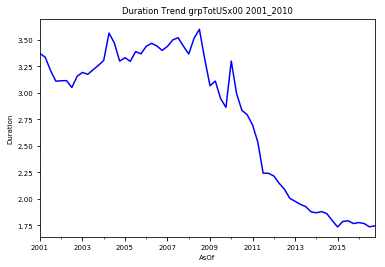

In [41]:
dy3['dur'].plot(c='b')
#dy3['dur2'].plot(c='r',ls='--')
#plt.ylim(0,5)
plt.title('Duration Trend '+grp+' '+r0)
#plt.ylim(ymin=0)
plt.ylabel('Duration')
plt.savefig('3mat_durtrend_'+grp+'_'+r0+'_'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [42]:
#dy3['dur'].plot(c='b',label='Duration')
#dy3['dur2'].plot(c='r',ls='--',label='DurAlt')
#plt.ylim(0,5)
#plt.title('Duration Trend '+grp+' '+r0)
#plt.legend(loc=0)
#plt.ylim(ymin=0)
#plt.ylabel('Duration')
#plt.savefig('3mat_durtrend2_'+grp+'_'+r0+'_'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
#plt.show()

In [43]:
dy3a = dy3.ix[:'2014']

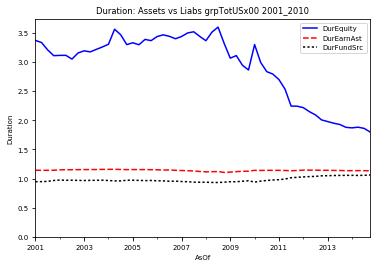

In [44]:
dy3a['dur'].plot(c='b',label='DurEquity')
dy3a['durA'].plot(c='r',ls='--',label='DurEarnAst')
dy3a['durL'].plot(c='k',ls=':',label='DurFundSrc')
plt.title('Duration: Assets vs Liabs '+grp+' '+r0)
plt.legend(loc=0)
plt.ylim(ymin=0)
plt.ylabel('Duration')
plt.savefig('3mat_durAL_'+grp+'_'+r0+'_'+str(rtyp)+'.png', dpi=400, bbox_inches='tight')
plt.show()

In [45]:
dy3[['dur']].mean()

dur    2.782499
dtype: float64

In [46]:
dy3.to_csv('durcalc_3mat_FDIC_'+grp+'_'+r0+'_exp'+str(rtyp)+'.csv')
'durcalc_3mat_FDIC_'+grp+'_'+r0+'_exp'+str(rtyp)+'.csv'

'durcalc_3mat_FDIC_grpTotUSx00_2001_2010_exp4.csv'

In [47]:
dy3.columns[0:100]

Index(['Grp', 'IDRSSD', 'nbr', 'Cert', 'eTotAst', 'eTotLn', 'eALLL', 'eOREO',
       'eGW', 'eOthInt', 'eTotEq', 'eTangEq', 'eDDep', 'eDDepNIB', 'eDDepIB',
       'eFDep', 'eFDepNIB', 'eFDepIB', 'eDDA', 'aTotAst', 'aDLn', 'aSFR',
       'aRE', 'aTotRE', 'aAg', 'aCI', 'aCard', 'aOthCsmr', 'aFLn', 'aLeas',
       'aTrad', 'aDFIB', 'aTreas', 'aMBS', 'aOSec', 'aFFS', 'aTotLn',
       'aTotLnLs', 'aOthLnLs', 'aTotSec', 'aOAstIB', 'aEarnAst', 'aNOW',
       'aSav', 'aCDun', 'aCDov', 'aDDepIB', 'aFDepIB', 'aFFP', 'aBorr',
       'aDepIB', 'aOLbIB', 'eDLn', 'eCxSFR', 'eCxOth', 'eCx', 'eFarm',
       'eSfRev', 'eSfFst', 'eSfSec', 'eSfTD', 'eMult', 'eOwOc', 'eOthCRE',
       'eCRE', 'eCREtot', 'eFinInst', 'eAg', 'eCIdom', 'eCIfor', 'eCard',
       'eOthRev', 'eAuto', 'eOthCsmr', 'eForGovt', 'eLeas', 'eUnearn',
       'nCxSFR', 'nCxOth', 'nCx', 'nFarm', 'nSfRev', 'nSfFst', 'nSfSec',
       'nSfTD', 'nMult', 'nOwOc', 'nOthCRE', 'nCRE', 'nCREtot', 'nREfor',
       'nFinInst', 'nAg', 'nCIdom', 'nCIf

In [48]:
dy3.columns[100:200]

Index(['nLeas', 'nTotLn', 'eBrok', 'eMMDA', 'eOthSav', 'eCDov250', 'eDepov250',
       'eIRAov250', 'eUninsDep', 'eT1rbc', 'eTotrbc', 'eT1Cap', 'eTotCap',
       'eTotRWA', 'eTotAstLev', 'iiSFR', 'iiOthRE', 'iiRE', 'iiAg', 'iiCI',
       'iiCard', 'iiOthCsmr', 'iiForGovt', 'iiOthDomLn', 'iiFLn', 'iiTotLn',
       'iiLeas', 'iiDFIB', 'iiTreas', 'iiMBS', 'iiOSec', 'iiTrad', 'iiFFS',
       'iiOthII', 'iiTotLnLs', 'iiOthLnLs', 'iiTotSec', 'iiOAstIB',
       'iiTotII_pc', 'iiTotII', 'ieNOW', 'ieSav', 'ieCDun', 'ieCDov',
       'ieFDepIB', 'ieFFP', 'ieOthBorr', 'ieNote', 'ieDepIB', 'ieOLbIB',
       'ieDDA', 'ieTotIE_pc', 'ieTotIE', 'iiNetII', 'isIntangExp', 'isProv',
       'isTotNII', 'isTotNIE', 'isPreTax', 'isNetInc', 'isOREOgl', 'isLnLsgl',
       'isOthAstgl', 'isHTMgl', 'isAFSgl', 'isFTE', 'ncoTotLn', 'ncoCxSFR',
       'ncoCxOth', 'ncoCx', 'ncoFarm', 'ncoSfRev', 'ncoSfFst', 'ncoSfSec',
       'ncoSfTD', 'ncoMult', 'ncoOwOc', 'ncoOthCRE', 'ncoCRE', 'ncoCREtot',
       'ncoREfor', 'nc

In [49]:
dy3.columns[200:300]

Index(['qiTotII', 'qiTotLn', 'qiRE', 'qiCI', 'qiCard', 'qiOthCsmr', 'qiLeas',
       'qiTotLnLs', 'qiOthLnLs', 'qiDFIB', 'qiTreas', 'qiMBS', 'qiOSec',
       'qiFFS', 'qiOAstIB', 'qiTotSec', 'qeTotIE', 'qeNOW', 'qeSav', 'qeCDun',
       'qeCDov', 'qeFFP', 'qeFDepIB', 'qeDepIB', 'qeBorr', 'qeOLbIB',
       'qncTotLn', 'qncCx', 'qncSfRev', 'qncSfTD', 'qncMult', 'qncCRE',
       'qncCIdom', 'qncCIfor', 'qncCard', 'qncOthCsmr', 'qncCREtot', 'qyNetII',
       'qyTotII', 'qyTotLn', 'qyRE', 'qyCI', 'qyCard', 'qyOthCsmr',
       'qyOthLnLs', 'qyDFIB', 'qyTreas', 'qyMBS', 'qyOthSec', 'qyFFS',
       'qyOAstIB', 'qyTotLnLs', 'qyTotSec', 'qrTotIE', 'qrNOW', 'qrSav',
       'qrCDun', 'qrCDov', 'qrFFP', 'qrBorr', 'qrOLbIB', 'qrDepIB', 'qrFDepIB',
       'rcTotLn', 'rcCx', 'rcSfRev', 'rcSfTD', 'rcMult', 'rcCRE', 'rcCREtot',
       'rcCIdom', 'rcCIfor', 'rcCard', 'rcOthCsmr', 'qcTotLn', 'qcCx',
       'qcSfRev', 'qcSfTD', 'qcMult', 'qcCRE', 'qcCREtot', 'qcCIdom',
       'qcCIfor', 'qcCard', 'qcOthCsm

In [50]:
dy3.columns[300:]

Index(['rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA', 'eBrok_Dep', 'eTEq_TTA',
       'eT1rb', 'eT1lv', 'eTotrb', 'eALLL_Ln', 'mxCx', 'mxSfFst', 'mxCRE',
       'mxCI', 'mxCard', 'mxDDA', 'eRWA_TA', 'lnTotAst', 'aCsmr', 'qyCsmr',
       'aSavNow', 'aCD', 'qrSavNow', 'qrCD', 'netDDA', 'durbal', 'dur',
       'durAbal', 'durA', 'durLbal', 'durL'],
      dtype='object')

In [51]:
## 5-year rolling mean table:
dy_r5y=pd.rolling_mean(dy3[dy3.columns[2:]],20,min_periods=20)
dy_r5y.dropna(how='all',inplace=True)
dy_r5y.to_csv('durcalc_FDIC_'+grp+'_'+r0+'_'+str(rtyp)+'_r5y.csv')
'durcalc_FDIC_'+grp+'_'+r0+'_'+str(rtyp)+'_r5y.csv'

'durcalc_FDIC_grpTotUSx00_2001_2010_4_r5y.csv'

In [52]:
dy3.to_csv('durcalc_3matbalyld_FDIC_'+grp+'_'+r0+'_'+str(rtyp)+'.csv')
'durcalc_3matbalyld_FDIC_'+grp+'_'+r0+'_'+str(rtyp)+'.csv'

'durcalc_3matbalyld_FDIC_grpTotUSx00_2001_2010_4.csv'

In [53]:
## stop here